In [83]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import json
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.base import BaseEstimator
from skimage.morphology import binary_closing
from skimage.morphology import disk

import annotation, image_render, hyspec_io, hyspec_ml, batch_process, misc, preprocess

In [52]:
# Paths
hyspec_dir = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef"
annotation_json = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/label_classes.json"
annotation_train_dir = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/Training"
annotation_val_dir = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/Validation"

annotation_train_pickle = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/M_Annotation/TrainingData.pickle"

# test_image = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_10-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr"
# test_image = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_9-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr"
test_image = "/media/mha114/Massimal/Bodo_Sandsund/Hyperspectral/20210602/Area/3b_R_rs_GeoRef/Sandsund_May2021_Pika_L_17-Radiance From Raw Data-Reflectance from Radiance Data and Downwelling Irradiance Spectrum-Georectify Airborne Datacube.bip.hdr"

In [3]:
# Read class dictionary
class_dict = annotation.read_hasty_metadata(annotation_json)

In [4]:
# Define classes that can be merged
classes_to_merge = [
    [
        'Zostera marina, healthy, dominant',
        'Zostera marina, healthy, common',
        'Zostera marina, healthy, sparse'
    ],
    [
        'Zostera marina, partly dead, with periphyton, dominant',
        'Zostera marina, partly dead, with periphyton, common',
        'Zostera marina, partly dead, with periphyton, sparse'
    ],
    [
        'Zostera marina, dead, with periphyton, dominant',
        'Zostera marina, dead, with periphyton, common',
        'Zostera marina, dead, with periphyton, sparse'
    ],
    [
        'Turf algae, dominant',
        'Turf algae, common',
        'Turf algae, sparse'
    ]
]

merged_class_names = [
    'Zostera marina, healthy',
    'Zostera marina, partly dead',
    'Zostera marina, dead',
    'Turf algae'
]

In [5]:
# Collect training data
# data = batch_process.collect_annotated_data(class_dict, hyspec_dir, annotation_train_dir)

In [6]:
# Save training data data to disk
# misc.pickle_save_data(data,annotation_train_pickle)

In [5]:
# Load data
data = misc.pickle_load_data(annotation_train_pickle)

In [6]:
# Extract wavelength vector from data structure
wl = data[0]['wavelength']

In [70]:
# Limit wavelength range (less noisy data)
#wl_ind = (wl >= 400) & (wl <= 900)
#X = X[:,wl_ind]
#wl = wl[wl_ind]


In [8]:
# Extract data matrix from data structure
(X_train,y_train) = annotation.annotation_data_to_matrix(data,class_dict)

In [12]:
# Merge classes
(class_dict_merged, y_train_merged) = annotation.merge_classes_in_label_vector(
        class_dict,y_train,classes_to_merge,merged_class_names)

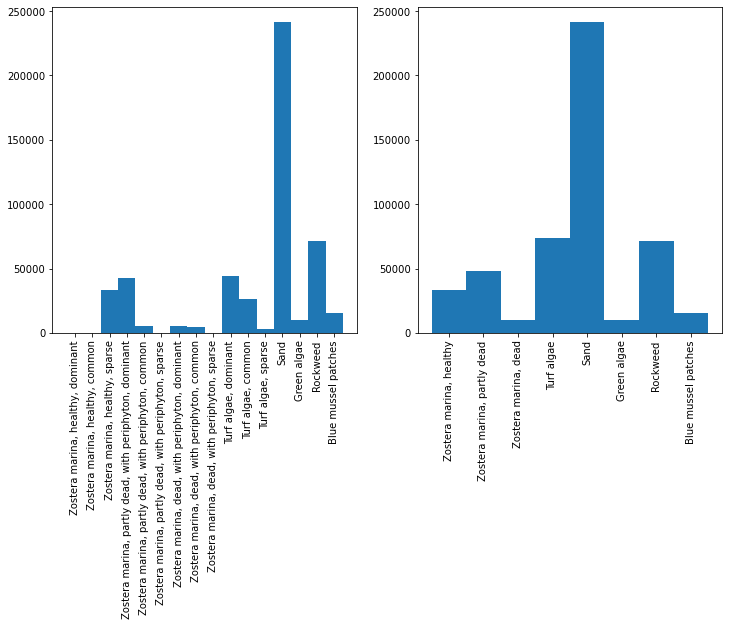

In [13]:
# Show histogram of number of class samples, before and after merging

class_name_list = [key for key in class_dict.keys()]
class_name_merged_list = [key for key in class_dict_merged.keys()]

fig, ax = plt.subplots(ncols=2,figsize=(12,6))

ax[0].hist(y_train,bins = np.arange(0,len(class_dict)+1)+0.5)
ax[0].set_xticks(np.arange(1,len(class_dict)+1))
ax[0].set_xticklabels(class_name_list, rotation='vertical')

ax[1].hist(y_train_merged,bins = np.arange(0,len(class_dict_merged)+1)+0.5)
ax[1].set_xticks(np.arange(1,len(class_dict_merged)+1))
ax[1].set_xticklabels(class_name_merged_list, rotation='vertical')

plt.draw()

The histograms show that in the original annotation, there are several empty classes, and some classes have very few samples. After merging classes, there are no empty classes, but there is still some imbalance. The most striking imbalance is that that the "sand" class is overrepresented. 

In [14]:
# Under-sample sand class
strategy = {class_dict_merged['Sand']:75000}
rus = RandomUnderSampler(random_state=0, sampling_strategy=strategy)

X_train_rs, y_train_rs = rus.fit_resample(X_train, y_train_merged)

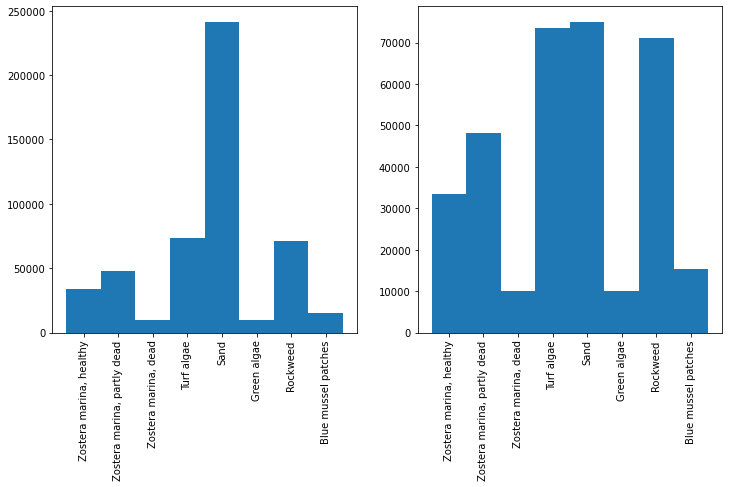

In [16]:
# Show histogram of number of class samples before/after undersampling sand

fig, ax = plt.subplots(ncols=2,figsize=(12,6))

ax[0].hist(y_train_merged,bins = np.arange(0,len(class_dict_merged)+1)+0.5)
ax[0].set_xticks(np.arange(1,len(class_dict_merged)+1))
ax[0].set_xticklabels(class_name_merged_list, rotation='vertical')

ax[1].hist(y_train_rs,bins = np.arange(0,len(class_dict_merged)+1)+0.5)
ax[1].set_xticks(np.arange(1,len(class_dict_merged)+1))
ax[1].set_xticklabels(class_name_merged_list, rotation='vertical')

plt.draw()

In [18]:
# Define wavelength indexing vector
wl_ind = (wl >= 400) & (wl <= 900)

In [22]:
# Define class for using only a subset of wavelengths
class ColumnExtractor(BaseEstimator):

    def __init__(self, col_ind):
        self.col_ind = col_ind
    
    def transform(self, X):
        cols = X[:,self.col_ind] # Extract columns
        return cols

    def fit(self, X, y=None):
        return self

In [25]:
testmat = np.matrix([[1,2,3,4],[5,6,7,8]])
test_col_ext = ColumnExtractor(col_ind=[False,True,True,False])

In [26]:
testmat

matrix([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [27]:
test_col_ext.transform(testmat)

matrix([[2, 3],
        [6, 7]])

In [20]:
#%% Create pipeline for feature normalization, PCA and classification
clf = make_pipeline(ColumnExtractor(col_ind = wl_ind),
                    StandardScaler(),
                    PCA(n_components=7), 
                    RandomForestClassifier(n_estimators=100)) 

In [21]:
# Fit classifier
clf.fit(X_train_rs,y_train_rs)

Pipeline(steps=[('columnextractor',
                 ColumnExtractor(col_ind=array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]))),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)),
                ('randomforestclassifier', RandomForestClassifier())

In [53]:
# Read hyperspectral file
(im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(test_image)

In [54]:
# Make image vectorizer
im_vz = hyspec_ml.ImageVectorizer(im.shape[0],im.shape[1])

In [55]:
# Apply classifier to whole image
y_pred = clf.predict(im_vz.image3d_to_matrix(im))
y_pred_im = im_vz.vector_to_image2d(y_pred)

In [57]:
# Set prediction results for "zero pixels" to zero (background)
zero_mask = np.all(im==0,axis=2)
y_pred_im[zero_mask] = 0

In [85]:
# Inpaint zero pixels inside image
import cv2
# y_pred_im_ip = preprocess.inpaint_masked(y_pred_im,zero_mask) # Doesn't currently work for 1-channel label images
y_pred_im_ip = cv2.inpaint(np.ubyte(y_pred_im),np.ubyte(zero_mask),3,cv2.INPAINT_NS) * binary_closing(~zero_mask,footprint=disk(3))

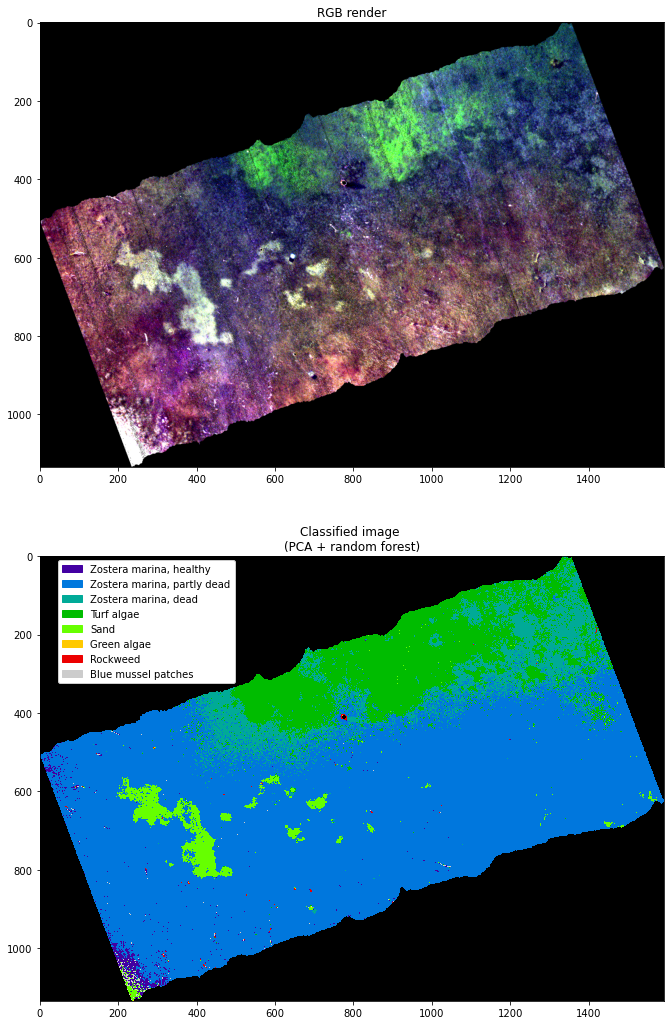

In [86]:
# Visualize result
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(12,18))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[0].set_title('RGB render')

# im_classified_show = np.copy(y_pred_im)
im_classified_show = np.copy(y_pred_im_ip)
im_classified_show[0] = 0 # Add single zero pixel to get scaling right
cl_im = ax[1].imshow(im_classified_show,interpolation='none',cmap='nipy_spectral')
ax[1].set_title('Classified image \n(PCA + random forest)')

# cl_im = ax[1].imshow(y_pred_im,interpolation='none',cmap='nipy_spectral')
# ax[1].set_title('Classified image \n(PCA + random forest)')

import matplotlib.patches as mpatches
class_names = list(class_dict_merged.keys())
values = np.unique(y_train_rs)
colors = [cl_im.cmap(cl_im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=class_names[i] ) for i in range(len(class_dict_merged)) ]
ax[1].legend(handles=patches, bbox_to_anchor=(0.03, 0.99), loc=2, borderaxespad=0., framealpha=1 )

